In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import ndjson
import os
import tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd

IMAGESIZE = 28



In [3]:
def parseSimplifiedDrawings(fileName, num):
        drawings = []
        with open(fileName, 'r') as fileStream:
            json_list = ndjson.load(fileStream)
            idx_range = min(num, len(json_list))
            for obj in range(idx_range):
                drawings.append(json_list[obj])
        return drawings

def prepare_datafiles(length, per_class, img_dir="images", data_dir="data"):
        absolute_path = "/Users/arthurjakobsson/Documents/10617/Project/"
        img_path = os.path.join(absolute_path, img_dir)
        data_path = os.path.join(absolute_path, data_dir)
        # img_list = sorted(os.listdir(img_path))
        # data_list = sorted(os.listdir(data_dir))
        data_list = ["apple.ndjson", "ant.ndjson", "car.ndjson", "book.ndjson", "leaf.ndjson", "hourglass.ndjson", "rabbit.ndjson", "truck.ndjson", "skyscraper.ndjson", "umbrella.ndjson"]
        img_list = ["apple.npy", "ant.npy", "car.npy", "book.npy", "leaf.npy", "hourglass.npy", "rabbit.npy", "truck.npy", "skyscraper.npy", "umbrella.npy"]
        # img_list = img_list[0:length] # cut classes it short
        # data_list = data_list[0:length] # cut it classes short

        print(img_list)
        print(data_list)
        img_npy = np.vstack([np.load(os.path.join(img_path, fname))[0:per_class] for fname in img_list])
        print(img_npy.shape)
        allDrawings = []
        for fname in data_list:
            drawings = parseSimplifiedDrawings("data/"+ fname, per_class)
            allDrawings += drawings
            print(fname)
        dicts = np.array([allDrawings]).T

        img_npy = np.array(img_npy)
        data_dir = data_list

        finalData = np.hstack([img_npy, dicts])
        print(finalData.shape)
        length = finalData.shape[0]
        np.save("AllData.npy", finalData)

# prepare_datafiles(0, per_class=10000)


In [4]:
class ImageDataLoader(Dataset):
    """Quick Draw and Image dataset."""

    def __init__(self, train):
        """
        Arguments:
            len: length of data requested
            img_dir (string): path to images
            data_dir (string): Directory with all the images.
        """
        allData = np.load("AllData.npy", allow_pickle=True)
        if train:
            data = []
            for i in range(10):
                data.append(allData[i*10000:i*10000+8000,])
            self.data = np.vstack(data)
        else:
            data = []
            for i in range(10):
                data.append(allData[i*10000+8000:(i+1)*10000,])
            self.data = np.vstack(data)


        self.length = self.data.shape[0]
        self.outputSize, self.countryDict = self.getUniqueCountryCount()

        self.xData = self.data[:,:(IMAGESIZE*IMAGESIZE)]
        dataInfo = self.data[:, IMAGESIZE*IMAGESIZE]
        print(dataInfo.shape)
        #countryCode = np.array([i["countrycode"] for i in dataInfo])
        self.category = np.array([i["word"] for i in dataInfo])
        # print(self.countryDict)
        self.classes = {
            "apple" : 0,
            "ant": 1,
            "car" : 2,
            "book" : 3,
            "leaf" : 4,
            "hourglass" : 5,
            "rabbit" : 6,
            "truck" : 7,
            "skyscraper" : 8,
            "umbrella" : 9
        }
        self.xData = self.data[:, :784]
        tempyData = self.data[:, 784]
        # print(tempyData)
        self.yData = []
        for val in tempyData:
            self.yData.append(self.classes[val["word"]])
        self.yData = np.array(self.yData)


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.__len__():
            print("Index too large for {}-sample dataset".format(self.__len__()))
            return

        dataPoint = self.data[idx]

        return xData, self.category

    def getUniqueCountryCount(self):
        d = {}
        for elem in self.data:
            code = elem[-1]["countrycode"]
            if code in d:
                d[code] +=1
            else:
                d[code] = 1
        return len(d), d

    def getData(self):
        return self.xData, self.yData

    def getCountryInfo(self):
        return self.countryDict

    def getClasses(self):
        return self.classes


In [5]:
def eda(func):
  countryD = func()
  fig, ax = plt.subplots(figsize=(18,4))
  ax.bar(range(len(countryD)), list(countryD.values()), align='center')
  plt.xticks(range(len(countryD)), list(countryD.keys()), rotation = 45)
  plt.show()

# dataloader = ImageDataLoader()
# eda(dataloader.getCountryInfo)


(80000,)
(20000,)
lenx 80000
leny 80000
0
100
200
300
400
500
600
700
Epoch 0: Train model accuracy 71.09%
epoch 0 training done
tensor([0, 0, 0,  ..., 9, 9, 9])
20000
20
0
10
acc  tensor(15653.)
count  20000
Epoch 0: Test model accuracy 78.26%
lenx 80000
leny 80000
0
100
200
300
400
500
600
700
Epoch 1: Train model accuracy 80.86%
epoch 1 training done
tensor([0, 0, 0,  ..., 9, 9, 9])
20000
20
0
10
acc  tensor(16532.)
count  20000
Epoch 1: Test model accuracy 82.66%
lenx 80000
leny 80000
0
100
200
300
400
500
600
700
Epoch 2: Train model accuracy 83.93%
epoch 2 training done
tensor([0, 0, 0,  ..., 9, 9, 9])
20000
20
0
10
acc  tensor(17008.)
count  20000
Epoch 2: Test model accuracy 85.04%
lenx 80000
leny 80000
0
100
200
300
400
500
600
700
Epoch 3: Train model accuracy 85.62%
epoch 3 training done
tensor([0, 0, 0,  ..., 9, 9, 9])
20000
20
0
10
acc  tensor(17208.)
count  20000
Epoch 3: Test model accuracy 86.04%
lenx 80000
leny 80000
0
100
200
300
400
500
600
700
Epoch 4: Train model a

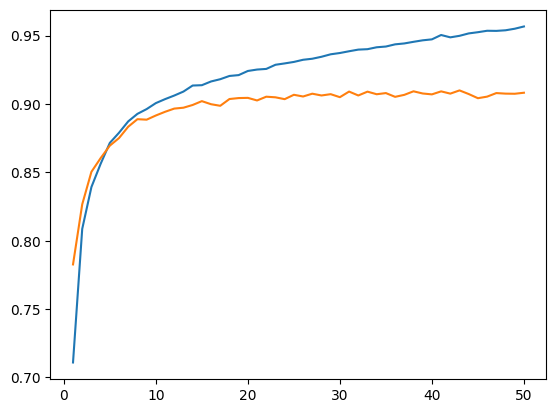

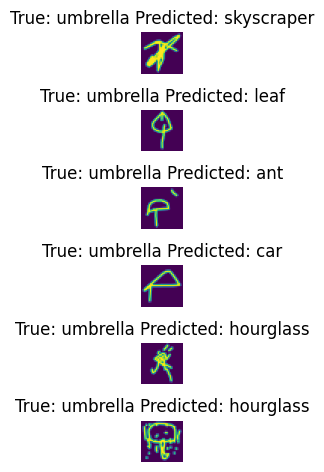

In [25]:

class OurCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(6272, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10) # add number of unique countries from model

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x



# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# batch_size = 32
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class trainLoop:
    def __init__(self, train_data_loader, eval_data_loader,
                        my_model, loss_function,
                        outputFolder, batch_size):
        # Note: We can access dataset from dataloader by doing dataloader.dataset
        self.train_data_loader = train_data_loader
        self.eval_data_loader = eval_data_loader
        self.my_model = my_model

        self.loss_function = loss_function
        self.outputFolder = outputFolder
        self.batch_size = batch_size
        self.optimizer = optim.SGD(self.my_model.parameters(), lr=1e-3)
        self.train_acc = []
        self.test_acc = []
        self.example_errors = []
        self.classes = {
            "apple" : 0,
            "ant": 1,
            "car" : 2,
            "book" : 3,
            "leaf" : 4,
            "hourglass" : 5,
            "rabbit" : 6,
            "truck" : 7,
            "skyscraper" : 8,
            "umbrella" : 9
        }

    def shuffleData(self, X, y, epoch):
        """
        DO NOT modify this function.

        Permute the training data for SGD.
        :param X: The original input data in the order of the file.
        :param y: The original labels in the order of the file.
        :param epoch: The epoch number (0-indexed).
        :return: Permuted X and y training data for the epoch.
        """
        np.random.seed(epoch)
        N = len(y)
        print("lenx", len(X))
        print("leny", len(y))
        ordering = np.random.permutation(N)
        return X[ordering], y[ordering]



    def runEpoch(self, epoch):
        xDataStart, yDataStart = self.train_data_loader.getData()
        xData, yData = self.shuffleData(xDataStart, yDataStart, epoch)
        xData, yData = xData.astype('f'), yData.astype('l')
        xData = torch.from_numpy(xData.reshape(-1,28,28))
        yData = torch.from_numpy(yData)
        acc=0
        count=0
        batchSize = self.batch_size
        for i in range(len(xData) // batchSize):
            if i % 100 == 0:
                print(i)
            batchX = xData[i*batchSize:i*batchSize + batchSize]
            batchY = yData[i*batchSize:i*batchSize + batchSize]
            batchX = np.reshape(batchX, (batchX.shape[0],1, batchX.shape[1], batchX.shape[2]))
            y_pred = self.my_model(batchX)
            loss = self.loss_function(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            acc += (torch.argmax(y_pred, 1) == batchY).float().sum()
            count += len(batchY)
        acc /= count
        self.train_acc.append(acc)
        print("Epoch %d: Train model accuracy %.2f%%" % (epoch, acc*100))

    def runModel(self, epochCount):
        for i in range(epochCount):
            self.runEpoch(i)
            print("epoch " + str(i) + " training done")
            acc = 0
            count = 0
            batchSize = 1000
            xData, yData = self.eval_data_loader.getData()
            xData, yData = xData.astype('f'), yData.astype('l')
            xData = torch.from_numpy(xData.reshape(-1,28,28))
            yData = torch.from_numpy(yData)
            print(yData)
            print(len(xData))
            print(len(xData) // batchSize)
            for j in range(len(xData) // batchSize):
                if j % 10 == 0:
                    print(j)
                batchX = xData[j*batchSize:j*batchSize + batchSize]
                batchY = yData[j*batchSize:j*batchSize + batchSize]
                batchX = np.reshape(batchX, (batchX.shape[0],1, batchX.shape[1], batchX.shape[2]))
                # print("here")
                # print(batchX)
                y_pred = self.my_model(batchX)
                # print(y_pred)
                # print(batchY)
                pred_argmax = torch.argmax(y_pred, 1)
                for k, pred_similarity in enumerate((pred_argmax == batchY)):
                    if not pred_similarity:
                        self.example_errors.append((batchX[k], batchY[k], pred_argmax[k]))

                acc += (pred_argmax == batchY).float().sum()
                count += len(batchY)
            print("acc ", acc)
            print("count ", count)
            acc /= count
            self.test_acc.append(acc)
            print("Epoch %d: Test model accuracy %.2f%%" % (i, acc*100))

        x = [(i+1) for i in range(epochCount)]
        plt.plot(x,self.train_acc, label="Train Accuracy")
        plt.plot(x,self.test_acc, label="Test Accuracy")
        plt.savefig('Accuracy.png')
        example_errors = self.example_errors.reverse()

        #save incorrect preds
        rows = 6
        columns = 1
        fig = plt.figure()
        for p in range(1,7):
            fig.tight_layout(pad=1.0)
            fig.add_subplot(rows, columns, p)
            x,y,pred = self.example_errors[p]
            plt.imshow(x[0])
            plt.axis('off')
            val_list = list(self.classes.values())
            key_list = list(self.classes.keys())
            y_lab = key_list[val_list.index(y)]
            pred_lab = key_list[val_list.index(pred)]
            plt.title('True: {} Predicted: {}'.format(y_lab, pred_lab))
        plt.savefig("Misclassified.png")


model = OurCNN()
loss_fn = nn.CrossEntropyLoss()
TrainDataLoader = ImageDataLoader(train=True)
TestDataLoader = ImageDataLoader(train=False)
training = trainLoop(TrainDataLoader, TestDataLoader, model, loss_fn, "models", 100)
training.runModel(50)
torch.save(model.state_dict(), "models/categoryModel1.pth")

